# PROJECT: Course Optimization for Data Science
## Optimization strategies for Support Vector Machines (SVM)

Authors: Alexandre Gramfort, Stéphane Gaiffas

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- derive the duals for SVMs with and without intercept
- implement an SVM using a blackbox convex toolbox (cvxopt in Python)
- implement your own solvers for the without intercept case: Proximal gradient, Coordinate Descent, Newton, Quasi-Newton
- Present a clear benchmark of the different strategies on small and medium scale datasets


## VERY IMPORTANT

This work must be done by pairs of students.
Each student must send their work before the 3rd of January at 23:59, using the moodle platform.
This means that **each student in the pair sends the same file**

On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called "Project".
This is where you submit your jupyter notebook file.

The name of the file must be constructed as in the next cell

### Gentle reminder: no evaluation if you don't respect this EXACTLY

#### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "yunzhi"
ln1 = "bai"
fn2 = "jie"
ln2 = "zheng"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["project", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

project_bai_yunzhi_and_zheng_jie.ipynb


Some imports

In [1]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt

## Important:

For Part 0 to Part 2 of the project you will need a working install of `cvxopt`.
You may struggle a bit to set it up.
The simplest way of getting it is by typing 

`pip install cvxopt`

if you have `pip` installed on your laptop.
If you **struggle too much please
contact us**.

## Part 0: SVM Classification with linear kernel

Let us consider the problem of binary classification from $n$ observations
$x_i \in \mathbb{R}^{d}$,
$1 \leq i \leq n$. We aim to learn a function:
$$f: x \in \mathbb{R}^{d}\mapsto y\in\{-1,+1\}$$
from the $n$ annotated training samples $(x_{i},y_{i})$ supposed i.i.d. from an unknown probability distribution on $\mathbb{R}^d \times \{-1,+1\}$. Once this function is learnt, it will be possible to use it to predict the label $y$ associated to a new sample $x$.

Margin and linear separating hyperplane:

<img src="separateur.png">

In the linear case, one looks for an affine function of $x$ of the form 
$f(x) = \mathrm{sign}(w^{\top} x)$ or $f(x)=\mathrm{sign}(w^{\top}x + b)$
with $w \in \mathbb{R}^d$ and $b \in \mathbb{R}$. The first case is referred
to as the **without intercept** case. Indeed the coefficient $b$ is known
as the intercept or bias term.

We will start by considering the case with intercept.

To learn $f$, we use the $n$ annotated samples and one looks for a hyperplane $P(w,b)$
such that the smallest distance to positive and negative samples
is the largest. This can be written as:
$$
 \max_{w,b} \min_{i=1:n} y_i \delta(x_{i},P(w,b)) \quad
 \text{where}\quad \delta(x_{i},w,b) = \frac{w^{\top}x_{i}+b}{\sqrt{w^{\top}w}} \enspace,
$$
since the signed distance from a sample $x_{i}$ to the hyperplane $P(w,b)$ is given by
$
\delta(x_{i},w,b)
$.
The principle described above is the maximisation of the *margin*.

One can notice that if the minimum of a set of values is larger than $m$ than all values of the set are larger than $m$. This leads to the following problem formulation:
$$
 \left\{
 \begin{array}{cll}
 \max_{(w,b)} \quad m \\
 \text{s.t.} \;\; &\forall i &y_i\dfrac{w^{\top}x_{i}+b}{\sqrt{w^{\top}w}}\geq m
 \end{array}
 \right. \enspace .
$$

The hyperplane separates the space in 2 half spaces, depending if $\delta(x_{i},w,b)$ is positive or negative.

Assuming all samples are linearly separable, convince yourself that the problem can be written as:
$$
(\mathcal{P}):  \left\{
 \begin{array}{cll}
 &\min_{(w,b)} \frac{1}{2}w^{\top}w
 \\
  &y_{i}(w^{\top}x_{i}+b)\geq 1, \quad \forall i\in \{1,\cdots,n\}
 \end{array}
 \right.
$$

### Questions

- Q1: Justify that the problem $(\mathcal{P})$ is convex.

**Q1 ANSWER:**

We can create a new vector W as a concatenation of w and b. It means W=[w,b]. So the objective function f can be written like $$f = \min_{W} \frac{1}{2}(I^{*}W)^{\top}(I^{*}W)$$
<br>
With I* the identity matrix but the last element is 0 instead of 1.
<br>
$$f(W_2)-f(W_1)-\nabla_{f}(W_1)*(W_2-W_1) = \frac{1}{2}(I^{*}W_2)^{\top}(I^{*}W_2)-\frac{1}{2}(I^{*}W_1)^{\top}(I^{*}W_1)-(I^{*}W_1)^{\top}(W_2-W_1)$$
Notice that $$(I^{*}W_1)^{\top}(W_2-W_1)=(I^{*}W_1)^{\top}(I^{*}W_2-I^{*}W_1)$$
So $$f(W_2)-f(W_1)-\nabla_{f}(W_1)*(W_2-W_1) = \frac{1}{2}(I^{*}W_2)^{\top}(I^{*}W_2)-\frac{1}{2}(I^{*}W_1)^{\top}(I^{*}W_1)-(I^{*}W_1)^{\top}(I^{*}W_2-I^{*}W_1)=\frac{1}{2}(I^{*}W_2-I^{*}W_1)^{\top}(I^{*}W_2-I^{*}W_1)\geq 0$$
So, the problem P is convex. $\blacksquare$<br>
****

- Q2: By looking at the saddle points of the Lagrangian $\mathcal{L}(w, b, \mu)$, $\mu \in \mathbb{R}_+^n$, show that the dual problem $(\mathcal{D})$ can be written as:
$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu-\mu^{\top}u
 \\
 \mathrm{s.c.}& y^{\top}\mu = 0
 \\
 \mathrm{and}& -\mu \leq  0
 \end{array}
 \right .
$$

with

$$
 G = \begin{bmatrix}y_{1}x_{1}^{\top} \\ \vdots \\ y_{n}x_{n}^{\top}\end{bmatrix}
$$

and $u = (1, \dots, 1) \in \mathbb{R}^n$.

We will **assume here qualification of the contraints**.

Remark: The problem $(\mathcal{D})$ is a *quadratic program* (QP) for which their exist off-the-shelf techniques. See below.

**Q2 ANSWER:**


From the primal problem, we can write the Lagrangian function as following:
$$L(w,b,\mu)=\frac{1}{2}w^{\top}w + (u-Gw-b*y)^{\top}\mu$$ with $\mu \in \mathbb{R}_+^n$ <br>
<br>
The dual function is:
$$D(\mu)=min_{(w,b)}L(w,b,\mu)$$
And the dual problem is :
$$max_{\mu}D(\mu)$$
<br>
For the dual function, the minimum is obtained when their partial derivations equal to 0:
$$ \frac{\partial L}{\partial b}=-y^{\top}\mu=0 \Rightarrow y^{\top}\mu=0 $$
$$ \frac{\partial L}{\partial w}=w-G^{\top}\mu=0 \Rightarrow w=G^{\top}\mu $$
<br>
So we can get $D(\mu)$ by the two above equations:
$$D(\mu)=\frac{1}{2}\mu^{\top}GG^{\top}\mu+u^{\top}\mu-\mu^{\top}GG^{\top}\mu-b*y^{\top}\mu = -\frac{1}{2}\mu^{\top}GG^{\top}\mu + u^{\top}\mu$$
So the dual problem is $$ max_{\mu} -\frac{1}{2}\mu^{\top}GG^{t}\mu+\mu^{\top}u 
\Rightarrow min_{\mu} \frac{1}{2}\mu^{\top}GG^{t}\mu-\mu^{\top}u$$

s.c.    $y^{\top}\mu=0$ and $-\mu \leq 0$ $\blacksquare$<br>
****

- Q3: Justify that given the estimated $\mu$, the prediction function for a new sample $x$ is given by:

$$
y = \mathrm{sign}(\sum_{i=1}^{n} \mu_i y_i x_i^\top x + b) \enspace .
$$

The vector $w$ is therefore equal to $\sum_{i=1}^{n} \mu_i y_i x_i$

**Q3 ANSWER:**

$y =\mathrm{sign}(w^{\top}x + b)$ and we know that $ w=G^{\top}\mu$. So
$$y =\mathrm{sign}(\mu^{\top}Gx + b)$$
Knowing that $\mu^{\top}G = \sum_{i=1}^{n} \mu_i y_i x_i^\top$, so
$$y = \mathrm{sign}(\sum_{i=1}^{n} \mu_i y_i x_i^\top x + b) \enspace .$$
And $$w=G^{\top}\mu=\sum_{i=1}^{n} \mu_i y_i x_i$$
$\blacksquare$<br>
****

## Part 1: Implementation of solver with intercept using cvxopt

The file svm_project_utils.py contains the code to generate some toy data and plot them

In [2]:
from svm_project_utils import plot_dataset, datasets

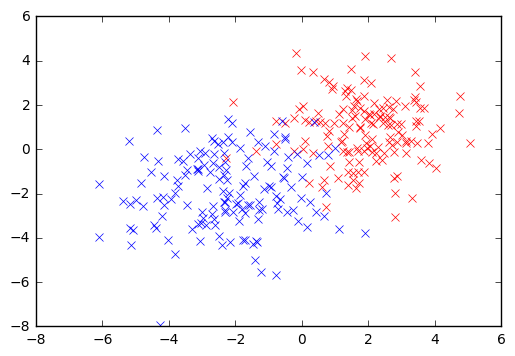

In [3]:
X, y = datasets(name='gaussian', n_points=300)
plot_dataset(X, y)

In [5]:
print(X.shape, y.shape)

(300, 2) (300,)


- The following function qp allows to solve a quadratic problem of the form:

$$
\left\{
  \begin{array}{cll}
  &\min_{(x)} \frac{1}{2}x^{\top} H x - e^\top x
  \\
   & \textrm{s.c.}\; A^\top x = b, 0 \leq x \leq C.
  \end{array}
  \right.
$$

In [7]:
import cvxopt


def qp(H, e, A, b, C=np.inf, l=1e-8, verbose=True):
    # Gram matrix
    n = H.shape[0]
    H = cvxopt.matrix(H)
    A = cvxopt.matrix(y, (1, n))
    e = cvxopt.matrix(-e)
    b = cvxopt.matrix(0.0)
    if C == np.inf:
        G = cvxopt.matrix(np.diag(np.ones(n) * -1))
        h = cvxopt.matrix(np.zeros(n))
    else:
        G = cvxopt.matrix(np.concatenate([np.diag(np.ones(n) * -1),
                                         np.diag(np.ones(n))], axis=0))
        h = cvxopt.matrix(np.concatenate([np.zeros(n), C * np.ones(n)]))

    # Solve QP problem
    cvxopt.solvers.options['show_progress'] = verbose
    solution = cvxopt.solvers.qp(H, e, G, h, A, b)
 
    # Lagrange multipliers
    mu = np.ravel(solution['x'])
    return mu

Definition of the linear kernel:

In [8]:
def kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.dot(X1[i], X2[j])
    return K

### Questions

- Q4: Modify the following cell to solve the SVM dual problem:

In [8]:
print y[:,None].shape
print type(y[:,None])
print y[None,:].shape

(300, 1)
<type 'numpy.ndarray'>
(1, 300)


In [9]:
print np.ones(2)

[ 1.  1.]


In [44]:
a = np.array([[1,2,3],[4,5,6],[7,8,9]])
print a
b = np.array([1,-1,0])[:,np.newaxis]
print b
print b.T*a
print a*b

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[ 1]
 [-1]
 [ 0]]
[[ 1 -2  0]
 [ 4 -5  0]
 [ 7 -8  0]]
[[ 1  2  3]
 [-4 -5 -6]
 [ 0  0  0]]


Number of support vectors: 2


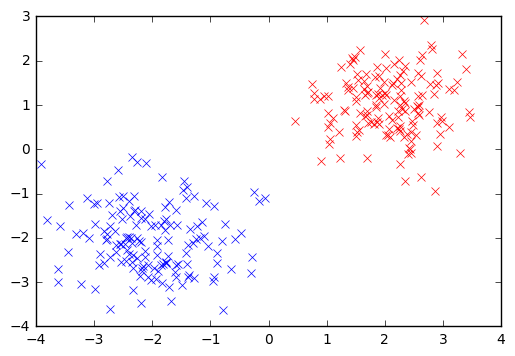

In [10]:
X, y = datasets(name='gaussian', n_points=300, sigma=0.7)
plot_dataset(X, y)

# TODO
def svm_solver(K, y, C=np.inf):
    n = y.shape[0]
    H = y[:,None]*K*y[None,:]  # GG.T = yi*yj*np.dot(xi,xj)
    e = np.ones(n) 
    A = y
    b = 0.
    mu = qp(H, e, A, b, C, l=1e-8, verbose=False)
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
    return mu_support, idx_support

K = kernel(X, X)

# Uncomment the following lines when your svm_solver is completed:
mu_support, idx_support = svm_solver(K, y)
print("Number of support vectors: %s" % idx_support.size)

- Q5: Compute w from mu and b

In [21]:
# TODO
y_support = y[idx_support]
X_support = X[idx_support]

w = np.dot(mu_support * y_support,X_support)
print ("w: ", w)

w:  [ 1.19874262  1.02297169]


In [18]:
w = np.sum((mu_support * y[idx_support])[: , None] * X[idx_support], axis=0)

In [19]:
print(w)

[ 1.19874262  1.02297169]


In [13]:
print mu_support.shape
print X_support.shape

(3,)
(3, 2)


- Q6: Using complementary slackness, explain how to obtain $b$ from $\mu$.

HINT: Use the fact that for all support vectors for which $\mu_i$ is non-zero one has $y_{i}(w^{t}x_{i}+b) = 1$.

In [22]:
# TODO
def compute_b(K, y, mu_support, idx_support):
    # TODO
    y_support = y[idx_support]
    K_support = K[idx_support][:, idx_support]
    
    g = np.dot(y_support*mu_support, (K[idx_support][:, idx_support])[:,0])
    b = 1./y_support[0] - g
    return b

b = compute_b(K, y, mu_support, idx_support)
print(b)

0.196737988401


- Q7: Verify that the constraints of the primal problem are satistified up to an acceptable numerical precision. You should verify that for all $i$ we have:

$$
y_{i}(w^{\top}x_{i}+b) \geq 1 - \epsilon
$$

using for example $\epsilon = 1e-5$.

In [24]:
# TODO
l = 1e-5
n = y.shape[0]
satisfied = True
for i in range(n):
    if (y[i]*(np.dot(w,X[i,:])+b)-1+l< 0): 
#        print "for i=", i, "the constraint 1e-5 is not satisfied" 
        satisfied = False
print(satisfied)

True


Check your code by running the following cell:

[-1. -1. -1. ...,  1.  1.  1.]


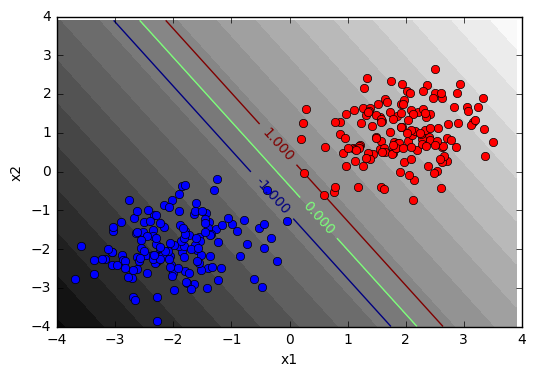

In [33]:
X, y = datasets(name='gaussian', n_points=300, sigma=0.7)

K = kernel(X, X)
mu_support, idx_support = svm_solver(K, y)
b = compute_b(K, y, mu_support, idx_support)

def plot_classif(X, y, mu_support, idx_support, b, kernel=kernel):
    # Calcul de la fonction de décision sur une grille
    X1, X2 = np.mgrid[-4:4:0.1, -4:4:0.1]
    na, nb = X1.shape
    X_test = np.c_[np.reshape(X1, (na * nb, 1)),
                   np.reshape(X2, (na * nb, 1))]

    # Calcul des produits scalaires
    X_support = X[idx_support]
    G = kernel(X_test, X_support)
    # Calcul de la fonction de décision
    decision = G.dot(mu_support * y[idx_support]) + b

    # Calcul du label prédit
    y_pred = np.sign(decision)
    print(y_pred)

    # Affichage des lignes de niveau de la fonction de decision
    plt.contourf(X1, X2, np.reshape(decision, (na, nb)), 20, cmap=plt.cm.gray)
    cs = plt.contour(X1, X2, np.reshape(decision, (na,nb)), [-1, 0, 1], color='g', linewidth=2)
    plt.clabel(cs, inline=1)
    plt.plot(X[y == 1,0], X[y == 1, 1], 'or', linewidth=2)
    plt.plot(X[y == -1,0], X[y == -1, 1], 'ob', linewidth=2)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])

plot_classif(X, y, mu_support, idx_support, b)

We will now change the value of $\sigma$ such that the problem is not linearily separable anymore.

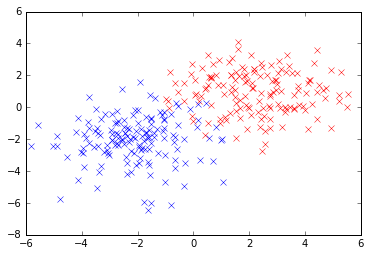

In [17]:
X, y = datasets(name='gaussian', n_points=300, sigma=1.5)
plot_dataset(X, y)

In [18]:
K = kernel(X, X)
mu_support, idx_support = svm_solver(K, y)
b = compute_b(K, y, mu_support, idx_support)
w = np.sum((mu_support * y[idx_support])[: , None] * X[idx_support], axis=0)

- Q8: Check that contraints of the problem are now violated.

In [19]:
# TODO
l = 1e-5
n = y.shape[0]
satisfied = True
for i in range(n):
    if (y[i]*(np.dot(w,X[i,:])+b)-1+l< 0): 
#        print "for i=", i, "the constraint 1e-5 is not satisfied" 
        satisfied = False
print satisfied

False


## Part 1: Non separable case with cvxopt

In practice it is very likely that the classes are not linearly separable.

A very natural idea is to relax the constraints $y_{i}(w^\top x_i + c) \geq 1$.
To do this, so called soft-margin SVM have been introduced using
so called slack variables: $\xi_{i}\geq 0$. The problem becomes:

$$
 y_{i}(w^\top x_i + b) \geq 1 - \xi_i, \; \xi_i \geq 0 \enspace .
$$

Note that if $\xi_i > 1$, the sample $x_{i}$ will be misclassified. To prevent
this case to be too frequent, an idea is to minimize the sum of the $\xi_{i}$.
This leads to the following problem:

$$
(P_{s}):  \left\{
 \begin{array}{ll}
 \min_{(w,b,\xi)} & \frac{1}{2}w^{\top}w + C \sum_i \xi_i
 \\
 \mathrm{s.t.} & y_{i}(w^{\top}x_{i}+b) \geq 1 - \xi_i\\
 \mathrm{and} & -\xi_i \leq 0
 \end{array}
 \right.
$$

The constant $C$ controls the regularisation.

### Questions

- Q9: Justify that $(P_{s})$ is a convex problem

**Q9 Answer:**

From the question 1, we have already justified that $min_{(w,b)} \frac{1}{2}w^{\top}w$ is convex. By the same logic, we could justified that $min_{(w,b,\xi)} \frac{1}{2}w^{\top}w$ is also convex.
<br>
And we could easily know that $min_{(w,b,\xi)}  C \sum_i \xi_i$ is also convex, as it is a linear function.
<br>
As the sum of two convex function is also a convex function, the $(P_{s})$ is a convex function.
****

- Show that a dual problem of $(P_{s})$ reads:

$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top}u
\\
\mathrm{s.t.}& y^{\top}\mu = 0
\\
\mathrm{et}& 0 \leq \mu \leq C
\end{array}
\right .
$$

**ANSWER:**

From the primal problem, we can write the Lagrangian function as following:
$$L(w,b,\xi,\mu,v)=\frac{1}{2}w^{\top}w + C u^{\top}\xi + (u-\xi-Gw-b*y)^{\top}\mu-\xi^{\top}v$$ with $\mu \in \mathbb{R}_+^n$ and $v \in \mathbb{R}_+^n$ <br>
<br>
The dual function is:
$$D(\mu)=min_{(w,b,\xi)}L(w,b,\xi,\mu,v)$$
And the dual problem is :
$$max_{\mu,v}D(\mu,v)$$
<br>
For the dual function, the minimum is obtained when their partial derivations equal to 0:
$$ \frac{\partial L}{\partial b}=-y^{\top}\mu=0 \Rightarrow y^{\top}\mu=0 $$
$$ \frac{\partial L}{\partial w}=w-G^{\top}\mu=0 \Rightarrow w=G^{\top}\mu $$
$$ \frac{\partial L}{\partial \xi}=Cu-\mu-v=0 \Rightarrow v=Cu-\mu $$
<br>
So we can get $D(\mu)$ by the three above equations:
$$D(\mu,v) = -\frac{1}{2}\mu^{\top}GG^{\top}\mu + u^{\top}\mu$$
with $\mu \geq 0$ and $v \geq 0$, using $v=Cu-\mu$, we get $0 \leq \mu \leq C$ <br><br>
Cause there is not v in the function D, we can rewrite it:
$$D(\mu) = -\frac{1}{2}\mu^{\top}GG^{\top}\mu + u^{\top}\mu$$
with $0 \leq \mu \leq C$ <br>.
<br>
So the dual problem is $$ max_{\mu} -\frac{1}{2}\mu^{\top}GG^{t}\mu+\mu^{\top}u 
\Rightarrow min_{\mu} \frac{1}{2}\mu^{\top}GG^{t}\mu-\mu^{\top}u$$

s.c.    $y^{\top}\mu=0$ and $0 \leq \mu \leq C$  $\blacksquare$<br>
****

- Q10: Modify your code from Q4 to handle the non-separable case.

[-1. -1. -1. ...,  1.  1.  1.]


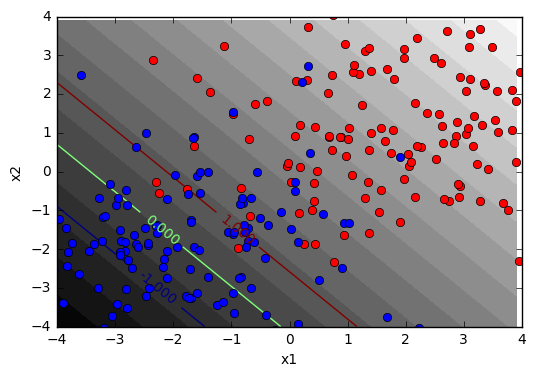

In [34]:
# TODO

X, y = datasets(name='gaussian', n_points=300, sigma=1.7)

K = kernel(X, X)
C = 0.5
mu_support, idx_support = svm_solver(K, y, C)
b = compute_b(K, y, mu_support, idx_support)

plot_classif(X, y, mu_support, idx_support, b)

- Q11: What is the influence of C on the number of support vectors? Justify this from an optimization stand point.

In [29]:
list_C = [1e-3, 1e-2, 1e-1, 1,10]
for C in list_C:
    mu_support, idx_support = svm_solver(K, y, C)
    print "C: ",C, "number of support vectors:", idx_support.size

C:  0.001 number of support vectors: 210
C:  0.01 number of support vectors: 104
C:  0.1 number of support vectors: 68
C:  1 number of support vectors: 60
C:  10 number of support vectors: 58


ANSWER HERE

## Part 2: non-linear case with kernels

Another scenario is when the boundary between classes is not linear.

To cope with this the idea is to use kernels.

- Q12: Denoting by $K(x_i, x_j)$ the dot product between samples show that dual problem and the decision function f(x) can be reformulated just using calls to $K$

**ANSWER:**

In the linar case, we have $$y = f(x) = \mathrm{sign}(\sum_{i=1}^{n} \mu_i y_i x_i^\top x + b) \enspace .$$
$$min_{\mu} \frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top}u$$

In the non-linear case, by denoting K(xi,xj) the dot product between samples, we can rewrite the above function and problem as following:
$$ f(x) =  \mathrm{sign}(\sum_{i=1}^{n} \mu_i y_i K(x_i^\top, x) + b) \enspace  $$
$$ min_{\mu} \frac{1}{2}\mu^{\top}(y^{\top}*K*y)\mu-\mu^{\top}u $$

We will use the clowns dataset to evaluate this:

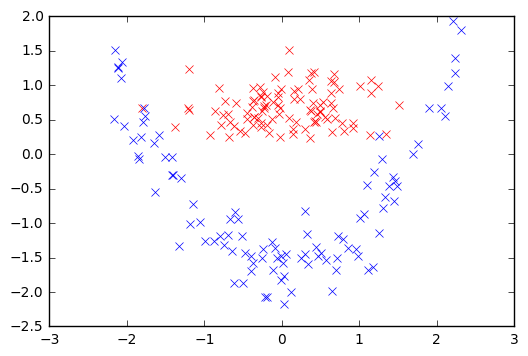

In [27]:
X, y = datasets(name='clowns', n_points=200, sigma=0.7)

plot_dataset(X, y)

- Q13: Update your kernel function so it computes the Gaussian kernel:

$$
    K(x_i, x_j) = \exp(-\gamma \| x_i - x_j \|)
$$

where $\gamma > 0$ is the kernel bandwidth.

In [35]:
y

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1

In [28]:
# TODO


from scipy import linalg

def rbf_kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    gamma = 3.
    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.exp(-gamma * np.sqrt(np.sum((X1[i] -X2[j])**2)))
    return K

Using the change above the follwing code should allow you to nicely separate the red from the blue dots

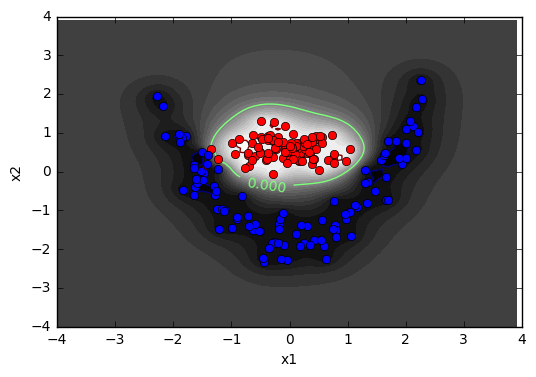

In [29]:
X, y = datasets(name='clowns', n_points=200, sigma=0.7)

K = rbf_kernel(X, X)
mu_support, idx_support = svm_solver(K, y, C=1.)
b = compute_b(K, y, mu_support, idx_support)

plot_classif(X, y, mu_support, idx_support, b, kernel=rbf_kernel)

## Part 3: Linear SVM without intercept

The problem of the formuation of SVMs with the intercept term $b$ is that
it leads to an annoying constraint in the dual, namely the $y^{t}\mu = 0$.

We will now see what we can do about it.

Let's consider the problem

$$
(P'_{s}):  \left\{
 \begin{array}{ll}
 \min_{(w,\xi)} & \frac{1}{2}w^{\top}w + C \sum_i \xi_i
 \\
 \mathrm{s.t.} & y_{i}(w^{\top}x_{i}) \geq 1 - \xi_i\\
 \mathrm{and} & -\xi_i \leq 0
 \end{array}
 \right.
$$

- Q14: Show that a dual problem of $(P'_{s})$ is given by:

$$
(\mathcal{D}):
\left\{
\begin{array}{lll}
\min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top} 1_n
\\
\mathrm{s.t.}& 0 \leq \mu \leq C
\end{array}
\right .
$$

**Q14 ANSWER:**

From the primal problem, we can write the Lagrangian function as following:
$$L(w,\xi,\mu,v)=\frac{1}{2}w^{\top}w + C u^{\top}\xi + (u-\xi-Gw)^{\top}\mu-\xi^{\top}v$$ 
with $\mu \in \mathbb{R}_+^n$ and $v \in \mathbb{R}_+^n$ <br>
<br>
The dual function is:
$$D(\mu)=min_{(w,\xi)}L(w,\xi,\mu,v)$$
And the dual problem is :
$$max_{\mu,v}D(\mu,v)$$
<br>
For the dual function, the minimum is obtained when their partial derivations equal to 0:
$$ \frac{\partial L}{\partial w}=w-G^{\top}\mu=0 \Rightarrow w=G^{\top}\mu $$
$$ \frac{\partial L}{\partial \xi}=Cu-\mu-v=0 \Rightarrow v=Cu-\mu $$
<br>
So we can get $D(\mu)$ by the three above equations:
$$D(\mu,v) = -\frac{1}{2}\mu^{\top}GG^{\top}\mu + u^{\top}\mu$$
with $\mu \geq 0$ and $v \geq 0$, using $v=Cu-\mu$, we get $0 \leq \mu \leq C$ <br><br>
Cause there is not v in the function D, we can rewrite it:
$$D(\mu) = -\frac{1}{2}\mu^{\top}GG^{\top}\mu + u^{\top}\mu$$
with $0 \leq \mu \leq C$ <br>.
<br>
So the dual problem is $$ max_{\mu} -\frac{1}{2}\mu^{\top}GG^{\top}\mu+\mu^{\top}u 
\Rightarrow min_{\mu} \frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top}u$$

s.c.    $0 \leq \mu \leq C$  $\blacksquare$<br>
****

- Q15: Rewrite the dual in the form:


$$
(\mathcal{D}): \min_{\mu} f(\mu) + g(\mu) .
$$

where $f$ is here a smooth function of $\mu$ with L-Liptschitz gradient and $g$ is a non-smooth function that is separable, namely:

$$
g(\mu) = \sum_{i=1}^n g_i(\mu_i)
$$

**Q15 ANSWER:**

$$f(\mu) = \frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top} 1_n$$ <br>
$$g(\mu) = I_{[0,C]}(\mu)$$ <br>
$$\nabla_{f}(\mu) = GG^{\top}\mu-1_n $$

The dual in the later form can be readily optimized using the methods that you have been studying in this class:

- Proximal gradient method with and without acceleration
- L-BFGS-B
- Coordinate descent

- Q16: Implement:

   - your own version of proximal gradient with and without acceleration
   - your own version of coordinate descent
   - an L-BFGS-B solver using `scipy.optimize.fmin_l_bfgs_b`

Note: We restrict ourselves to linear kernel here.

Note: To handle separating hyperplanes which do not pass throw zero (due to abscence of intercept)
you will add a column of ones to X. You can use something like this:

`X = np.concatenate((X, np.ones((len(X), 1))), axis=1)`

You will test your implementations on the Gaussian blobs and evaluate the performance of your implementations in terms of computation time on problems where the matrix $G G^\top$ can fit in memory.

You should reuse as much as possible the convergence evaluation code that you used during the labs.

For a coordinate descent method to be fast you need to have smart updates. You're expected to
come up with these smart updates in the problem at hand.

BONUS : With a smart implementation of the coordinate descent you should be able to scale the optimization to tens of thousands of samples ie cases where $G G^\top$ does not fit in memory anymore.

**IMPORTANT : This question Q16 is the most important and will constitute half of the final grade on the project !**

In [116]:
def svm_solver_1(K, y, C=np.inf):
    n = y.shape[0]
    H = y[:,None]*K*y[None,:]  # GG.T = yi*yj*np.dot(xi,xj)
    e = np.ones(n) 
    A = np.zeros(y.shape)
    b = 0.
    mu = qp(H, e, A, b, C, l=1e-8, verbose=False)
    return mu

In [117]:
X, y = datasets(name='gaussian', n_points=300, sigma=1.7)
n,p = X.shape
K = kernel(X, X)
C = 0.5
mu_support, idx_support = svm_solver(K, y, C)
mu_true = svm_solver_1(K, y, C)[:,np.newaxis]
y = np.array(y)[:,np.newaxis]
mu0 = np.zeros(mu_true.shape)

### 1.1 Proximal gradient without acceleration

In [125]:
def f(u):
    return (1/2.*u.T.dot(y.T*K*y).dot(u)-np.sum(u))[0,0]

def grad_f(u):
    return (y.T*K*y).dot(u)-np.ones(u.shape)

def g(u):
    for i in u:
        if i > C:
            return np.inf
        if i < 0:
            return np.inf
    return 0

def prox_g(u):
    tmp = u.copy()
    n = len(tmp)
    for i in np.arange(n):
        if tmp[i] < 0:
            tmp[i] = 0
        if tmp[i] > C:
            tmp[i] = C
    return tmp

In [126]:
from numpy import linalg as LA
def lip_svm(y,K):
    """Lipschitz constant for linear squares loss"""  
    tmp = y.T*K*y
    w,v = LA.eig(tmp)
    return max(w)
    
    
def ista(mu0, f, grad_f, g, prox_g, step, n_iter=50,
         mu_true=mu_true, verbose=True):
    """Proximal gradient descent algorithm
    """
    mu = mu0.copy()
    mu_new = mu0.copy()
    n_samples, n_features = X.shape
    
    f_min = f(mu_true)
    print f_min
    # estimation error history
    errors = []
    # Current objective
    obj = f(mu) + g(mu)
    # Current estimation objectif error
    err = LA.norm(obj - f_min) / LA.norm(f_min)
    errors.append(err)

    if verbose:
        print "Lauching ISTA solver..."
        print ' | '.join([name.center(8) for name in ["it", "err"]])
    for k in range(n_iter + 1):

        #### TODO ####
        mu = prox_g(mu_new - step * grad_f(mu_new))
        mu_new = mu.copy()
        
        obj = f(mu) + g(mu)
        err = LA.norm(obj - f_min) / LA.norm(f_min)
        errors.append(err)
        if k % 10 == 0 and verbose:
            print ' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % err).rjust(8)])
    return mu, errors

In [127]:
mu_final,errs=ista(mu0, f, grad_f, g, prox_g, 1./lip_svm(y,K), n_iter=1000,
         mu_true=mu_true, verbose=False)

-28.5508112861


In [128]:
print errs[-1]

0.143265390553


In [133]:
def fista(mu0, f, grad_f, g, prox_g, step, n_iter=50,
         mu_true=mu_true, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    mu = mu0.copy()
    mu_new = mu0.copy()
    # An extra variable is required for FISTA
    z = mu0.copy()
    
    f_min = f(mu_true)
    # estimation error history
    errors = []
    # Current objective
    obj = f(mu) + g(mu)
    # Current estimation objectif error
    err = LA.norm(obj - f_min) / LA.norm(f_min)
    errors.append(err)
    
    t = 1.
    t_new = 1.    
    if verbose:
        print "Lauching FISTA solver..."
        print ' | '.join([name.center(8) for name in ["it", "err"]])
    for k in range(n_iter + 1):
        # L is defined out of this fonction
        mu_new=prox_g(z-step*grad_f(z))
        t_new=(1+np.sqrt(1+4*t*t))/2
        z=mu_new+(t-1)/t_new*(mu_new-mu)
        
        t=t_new.copy()
        mu=mu_new.copy()

        obj = f(mu) + g(mu)
        err = LA.norm(obj - f_min) / LA.norm(f_min)
        errors.append(err)
        if k % 1 == 0 and verbose:
            print ' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % err).rjust(8)])
    return mu, np.array(errors)

In [134]:
mu_final,errs=fista(mu0, f, grad_f, g, prox_g, 1./lip_svm(y,K), n_iter=1000,
         mu_true=mu_true, verbose=False)

In [135]:
print errs

[ 1.          0.99744948  0.99614547 ...,  0.0723227   0.07232272
  0.07232274]


### CD

In [141]:
def prox_g_coor(u):
    if u < 0:
        return 0
    if u > C:
        return C
    return u


L=y.T*K*y

def grad_coor(u,i):
    return L[i].dot(u)-1

In [155]:
def coordinate_descend(mu0,f, g, prox_g, grad_coor, n_iter=50,
              mu_true=mu_true, epsilon=0.1, verbose=True):
    """Proximal gradient descent algorithm

    Minimize :
    
    1/2 ||b−Ax||^2 + s * g(x)
    
    with coodinate descent.
    """
    mu = mu0.copy()
    mu_new = mu0.copy()
    n_features = len(mu0)

    f_min = f(mu_true)
    # estimation error history
    errors = []
    # Current objective
    obj = f(mu) + g(mu)
    # Current estimation objectif error
    err = LA.norm(obj - f_min) / LA.norm(f_min)
    errors.append(err)

    if verbose:
        print "Lauching Coordinate Descent solver..."
        print ' | '.join([name.center(8) for name in ["it", "err"]])

    for k in range(n_iter + 1):

        #### TODO ####
        i = np.random.randint(n_features)
        step = 1./LA.norm(L[i])
        mu_new[i,0] = prox_g(mu[i,0]-step*grad_coor(mu,i))
        mu[i,0]=mu_new[i,0]
        
        
        obj = f(mu) + g(mu)
        # Current estimation objectif error
        err = LA.norm(obj - f_min) / LA.norm(f_min)
        errors.append(err)
        if k % 10 == 0 and verbose:
            print ' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % err).rjust(8)])
        if abs(err -f_min) < epsilon:
            return mu,errors
    return mu,errors

In [156]:
mu_final,errs=coordinate_descend(mu0, f, g, prox_g_coor, grad_coor, n_iter=10000,
         mu_true=mu_true, verbose=False)

In [157]:
errs[-1]

0.0026780840542395229

### L-BFGS-B

In [124]:
# Conjugate gradient descent
from scipy.optimize import fmin_l_bfgs_b

def loss(u):
    return f(u)+g(u)

#bfgs_inspector = inspector(model.loss, x_truth, verbose=True)
x_bfgs, f_min, _ = fmin_l_bfgs_b(loss, mu0, approx_grad=True, maxiter=1000)

IndexError: invalid index to scalar variable.

In [115]:
print f_min

-0.0821550676859


In [ ]:
# TODO

from scipy.optimize import fmin_l_bfgs_b